In [1]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano


import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

np.random.seed(13378) # for reproducibility
from sklearn.cross_validation import train_test_split

from keras.models import Sequential
#from keras.layers import containers
from keras.layers import Input, Dense
#from keras.layers.core import AutoEncoder
from keras.activations import sigmoid
from keras.utils import np_utils

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *
from keras.layers.normalization import BatchNormalization
nb_classes = 10
#nb_hidden_layers = [3072, 2900, 2300, 1700, 1100, 750, 500, 400, 300, 150, 75, 40] --->around 20% accuracy
nb_hidden_layers = [3072, 2048, 1024, 600] 
encoding_dim=600


Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: GeForce 920M (CNMeM is disabled, cuDNN not available)
/home/mrafi123/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [2]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [3]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)


(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [4]:
# the data, shuffled and split between train and test sets
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print(Y_train.shape, 'train labels')
print(Y_test.shape, 'test labels')

(50000, 3072) train samples
(10000, 3072) test samples
(50000, 10) train labels
(10000, 10) test labels


In [39]:
# Layer-wise pretraining
pt_encoders = []
#X_train_tmp is used for pre-training only
X_train_tmp = np.copy(x_train)  
print(X_train_tmp.shape)



(50000, 3072)


In [40]:
# Pre-Training 
for i, (n_in, n_out) in enumerate(zip(nb_hidden_layers[:-1], nb_hidden_layers[1:]), start=1):
    print('Training the layer {}: Input {} -> Output {}'.format(i, n_in, n_out))
    
    # this is our input placeholder
    pt_input_img = Input(shape=(n_in,))
    # "encoded" is the encoded representation of the input
    pt_encoded = Dense(n_out, activation='sigmoid')(pt_input_img)
    # "decoded" is the lossy reconstruction of the input
    pt_decoded = Dense(n_in, activation='sigmoid')(pt_encoded)

    # this model maps an input to its reconstruction
    # we will not need a model to reconstruct
    pt_autoencoder = Model(input=pt_input_img, output=pt_decoded)
    
    # this model maps an input to its encoded representation
    # this is the important model for encoding and need to be stacked
    pt_encoder = Model(input=pt_input_img, output=pt_encoded)

    # create a placeholder for an encoded  input
    pt_encoded_input = Input(shape=(n_out,))
    # retrieve the last layer of the autoencoder model
    pt_decoder_layer = pt_autoencoder.layers[-1]
    # create the decoder model
    pt_decoder = Model(input=pt_encoded_input, output=pt_decoder_layer(pt_encoded_input))

    print('compiling...')
    pt_autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy')
    print('fiting.pretraining for just few epochs..')
    
    #induce noise in pre-training

    #noise_factor = 0.2
    #X_train_tmp_noisy = X_train_tmp + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_tmp.shape) 
    #X_train_tmp_noisy = np.clip(X_train_tmp_noisy, 0., 1.)
    #print('Shape of noisy input ', X_train_tmp_noisy.shape)

    pt_autoencoder.fit(X_train_tmp, X_train_tmp,
                nb_epoch=1,
                batch_size=32,
                shuffle=True)
    
    # encode and decode some digits
    # note that we take them from the *test* set
    #encoded_imgs = encoder.predict(X_train_tmp)
    #decoded_imgs = decoder.predict(encoded_imgs)
    
    #SDAE needs new set of training examples with encoded rep for the next stack
    X_train_tmp = pt_encoder.predict(X_train_tmp)
    print('shape of new traintmp while pretraining ',X_train_tmp.shape)
    
    pt_encoders.append(pt_encoder)
    print('Pre-training Encoder ',pt_encoder.summary())
    print('Pre-training Decoder ',pt_decoder.summary())
    print('Pre-training Autoencoder ',pt_autoencoder.summary())
print(pt_encoders)


Training the layer 1: Input 3072 -> Output 2048
compiling...
fiting.pretraining for just few epochs..
Epoch 1/1
50000/50000 [==============================] - 111s - loss: 11560.4210   
shape of new traintmp while pretraining  (50000, 2048)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 2048)          6293504     input_9[0][0]                    
Total params: 6293504
____________________________________________________________________________________________________
Pre-training Encoder  None
____________________________________________________________________________________________________
Lay

In [41]:
print(pt_encoders)

[<keras.engine.training.Model object at 0x7f1803b18908>, <keras.engine.training.Model object at 0x7f1803766668>, <keras.engine.training.Model object at 0x7f188d7c2470>]


In [42]:
for encoder in pt_encoders:
    #model.add(encoder)
    #x=model.get_weights()
    print('Type of 1st Layer ',encoder.layers[0])

    #print(encoder.layers[0].get_config())
    print('Length of Weights in 1st Layer type ',len(encoder.layers[0].get_weights()))
    
    print('Type of 2nd Layer ',encoder.layers[1])

    #print(encoder.layers[1].get_config())
    print('Length of Weights in 2nd Layer type',len(encoder.layers[1].get_weights()))
    
    #print('Type of 3rd Layer ',encoder.layers[2])
    #print('Length of Weights in 3rd Layer type',len(encoder.layers[2].get_weights()))



Type of 1st Layer  <keras.engine.topology.InputLayer object at 0x7f1803365a20>
Length of Weights in 1st Layer type  0
Type of 2nd Layer  <keras.layers.core.Dense object at 0x7f1803b19668>
Length of Weights in 2nd Layer type 2
Type of 1st Layer  <keras.engine.topology.InputLayer object at 0x7f18037737f0>
Length of Weights in 1st Layer type  0
Type of 2nd Layer  <keras.layers.core.Dense object at 0x7f180376f978>
Length of Weights in 2nd Layer type 2
Type of 1st Layer  <keras.engine.topology.InputLayer object at 0x7f188d7b2da0>
Length of Weights in 1st Layer type  0
Type of 2nd Layer  <keras.layers.core.Dense object at 0x7f188d7b2390>
Length of Weights in 2nd Layer type 2


In [43]:

print (len(nb_hidden_layers))
print (nb_hidden_layers[0])
print (nb_hidden_layers[-1])

print (nb_hidden_layers[1])
print (nb_hidden_layers[2])
print (nb_hidden_layers[3])
print (nb_hidden_layers[4])

#print (nb_hidden_layers[5])
#print (nb_hidden_layers[6])

## List out of range
print (nb_hidden_layers[-1])



4
3072
600
2048
1024
600


IndexError: list index out of range

In [44]:
# Build the top model to Dimension reduction
input_img = Input(shape=(nb_hidden_layers[0],))
top_encoded = Dense(nb_hidden_layers[1], activation='relu')(input_img)
for i in range(len(nb_hidden_layers) - 2) :

    top_encoded = Dense(nb_hidden_layers[i+2], activation='relu')(top_encoded)
    #model.add(BatchNormalization())
    #top_encoded = BatchNormalization()(top_encoded)
    
#top_encoded = Dense(nb_hidden_layers[3], activation='sigmoid')(top_encoded)

# add the below line to deconstruct
top_decoded = Dense(nb_hidden_layers[len(nb_hidden_layers) - 2], activation='relu')(top_encoded)

for i in reversed(range(len(nb_hidden_layers)-2)) :
    top_decoded = Dense(nb_hidden_layers[i], activation='relu')(top_decoded)

top_autoencoder = Model(input=input_img, output=top_decoded)
print('Top autoencoder model',top_autoencoder.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 2048)          6293504     input_15[0][0]                   
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 1024)          2098176     dense_22[0][0]                   
____________________________________________________________________________________________________
dense_24 (Dense)                 (None, 600)           615000      dense_23[0][0]                   
___________________________________________________________________________________________

In [45]:
# this model maps an input to its encoded representation
top_encoder_only = Model(input=input_img, output=top_encoded)
print('Top encoder only model',top_encoder_only.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_15 (InputLayer)            (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_22 (Dense)                 (None, 2048)          6293504     input_15[0][0]                   
____________________________________________________________________________________________________
dense_23 (Dense)                 (None, 1024)          2098176     dense_22[0][0]                   
____________________________________________________________________________________________________
dense_24 (Dense)                 (None, 600)           615000      dense_23[0][0]                   
Total params: 9006680
_____________________________________________________________________

In [46]:
# create a placeholder for an encoded  input
top_encoded_input = Input(shape=(nb_hidden_layers[-1],))
# retrieve the last layer of the autoencoder model
#top_decoder_layer = top_autoencoder.layers[-1]
# create the decoder model
#top_decoder_only = Model(input=top_encoded_input, output=top_decoder_layer(top_encoded_input))
top_decoded = Dense(nb_hidden_layers[len(nb_hidden_layers) - 2], activation='sigmoid')(top_encoded_input)

for i in reversed(range(len(nb_hidden_layers)-2)) :
    top_decoded = Dense(nb_hidden_layers[i], activation='sigmoid')(top_decoded)
top_decoder_only = Model(input=top_encoded_input, output=top_decoded)

print('Top decoder only model',top_decoder_only.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_16 (InputLayer)            (None, 600)           0                                            
____________________________________________________________________________________________________
dense_28 (Dense)                 (None, 1024)          615424      input_16[0][0]                   
____________________________________________________________________________________________________
dense_29 (Dense)                 (None, 2048)          2099200     dense_28[0][0]                   
____________________________________________________________________________________________________
dense_30 (Dense)                 (None, 3072)          6294528     dense_29[0][0]                   
Total params: 9009152
_____________________________________________________________________

In [47]:
print(top_autoencoder.layers[0])
print(len(top_autoencoder.layers[0].get_weights()))

print(top_autoencoder.layers[1])
print(len(top_autoencoder.layers[1].get_weights()))

print(top_autoencoder.layers[2])
print(len(top_autoencoder.layers[2].get_weights()))

print(top_autoencoder.layers[3])
print(len(top_autoencoder.layers[3].get_weights()))

print(top_autoencoder.layers[4])
print(len(top_autoencoder.layers[4].get_weights()))

###index out of range
print(top_autoencoder.layers[6])
print(len(top_autoencoder.layers[6].get_weights()))

print(top_encoder_only)

0
2
2
2
2
2


In [48]:
# copy the weights from the pre-trained model to the current DR model
i=1
for encoder in pt_encoders:
    print('i is ',i)
    # stack the first models encoded layer and set weights
    print(len(encoder.layers[1].get_weights()))
    top_autoencoder.layers[i].set_weights(encoder.layers[1].get_weights())
    print(len(top_autoencoder.layers[i].get_weights()))
    i+=1
    #if i == len(nb_hidden_layers)+1:
    #    break


i is  1
2
2
i is  2
2
2
i is  3
2
2


In [49]:
from sklearn.cross_validation import train_test_split

s_train, s_valid = train_test_split(x_train, test_size=0.2)
#v_train, v_valid = train_test_split(Y_train, test_size=0.3)

noise_factor = 0.2
s_train_noisy = s_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_train.shape) 
s_valid_noisy = s_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=s_valid.shape) 

s_train_noisy = np.clip(s_train_noisy, 0., 1.)
s_valid_noisy = np.clip(s_valid_noisy, 0., 1.)

print(s_train_noisy.shape)
print(s_valid_noisy.shape)

(40000, 3072)
(10000, 3072)


In [50]:
nb_epoch=50
batch_size=128

sdae_weights_path = os.path.join('cifar10_weights_sdae_' + str(len(nb_hidden_layers)) + 
                                  '_epoch_'+str(nb_epoch)+
                                  '_batch_'+str(batch_size) +
                                  '_encoded_'+str(encoding_dim) +
                                  '.h5')
print(sdae_weights_path)

cifar10_weights_sdae_4_epoch_50_batch_128_encoded_600.h5


In [51]:
print(top_autoencoder)

top_autoencoder.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy',metrics=['accuracy'])
score = top_autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test score before fine turning:', score[0])
print('Test accuracy before fine turning:', score[1])
callbacks = [
        EarlyStopping(monitor='val_loss', patience=2, verbose=1),
        ModelCheckpoint(sdae_weights_path, monitor='val_loss', save_best_only=True, verbose=1),

]
top_autoencoder.fit(s_train_noisy, s_train, batch_size=batch_size, nb_epoch=nb_epoch,
                    validation_data=(s_valid_noisy, s_valid),
                    callbacks=callbacks)
score = top_autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test score after fine turning:', score[0])
print('Test accuracy after fine turning:', score[1])

10000/10000 [==============================] - 4s     
Test score before fine turning: 17436.4547312
Test accuracy before fine turning: 0.0004
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 47s - loss: 11767.8786 - acc: 4.7500e-04 - val_loss: 11700.3896 - val_acc: 0.0028
Epoch 2/50
40000/40000 [==============================] - 46s - loss: 11627.7465 - acc: 0.0022 - val_loss: 11674.1807 - val_acc: 0.0026
Epoch 3/50
40000/40000 [==============================] - 47s - loss: 11605.0809 - acc: 0.0028 - val_loss: 11647.1380 - val_acc: 4.0000e-04
Epoch 4/50
40000/40000 [==============================] - 47s - loss: 11590.7818 - acc: 0.0038 - val_loss: 11638.8932 - val_acc: 0.0040
Epoch 5/50
40000/40000 [==============================] - 47s - loss: 11582.8756 - acc: 0.0040 - val_loss: 11630.6985 - val_acc: 0.0043
Epoch 6/50
40000/40000 [==============================] - 48s - loss: 11576.4437 - acc: 0.0046 - val_loss: 11625.9262 -

In [52]:
train_encoded_imgs = top_encoder_only.predict(x_train,batch_size=batch_size, verbose=1)

50000/50000 [==============================] - 7s     


In [53]:
print (train_encoded_imgs)

[[  0.           0.          11.6048851  ...,   0.           0.
   74.32392883]
 [  0.           0.          12.16503811 ...,   0.           0.
   50.70541763]
 [  0.           0.          34.65932846 ...,   0.          15.35997868
   45.85231018]
 ..., 
 [  0.           3.68109536   0.         ...,   0.           0.
   25.24523735]
 [  0.           0.           0.         ...,   0.           0.
   64.88563538]
 [ 24.2572422    0.           6.68797159 ...,   0.           1.19001412
   39.62924576]]


In [54]:
print(train_encoded_imgs.shape)

(50000, 600)


In [55]:
test_encoded_imgs = top_encoder_only.predict(x_test,batch_size=batch_size, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

In [56]:
print (test_encoded_imgs)

[[ 18.88938141   0.          26.62273026 ...,   0.           0.
   57.46445465]
 [  0.           0.          31.71945572 ...,   0.           0.
   33.53824234]
 [ 24.86460686   0.           8.113451   ...,   0.           0.          41.4691925 ]
 ..., 
 [  0.           0.          30.33056641 ...,   0.           0.
   32.78119278]
 [  0.           0.          13.68480396 ...,   0.           0.
   50.99875259]
 [  8.57558727   0.          15.70159245 ...,   0.           0.
   68.09013367]]


In [57]:
test_decoded_imgs = top_decoder_only.predict(test_encoded_imgs,batch_size=batch_size, verbose=1)

 9984/10000 [============================>.] - ETA: 0s

In [58]:
test_decoded_imgs.shape

(10000, 3072)

In [59]:
print(test_encoded_imgs.shape)

(10000, 600)


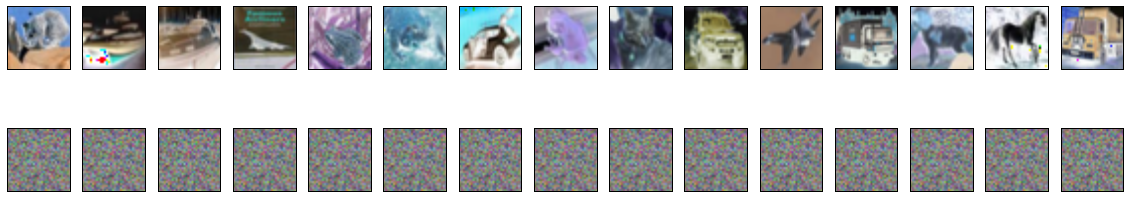

In [60]:

n = 15  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(test_decoded_imgs[i].reshape(32, 32,3))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [61]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(train_encoded_imgs, Y_train)

In [62]:
y_pred = clf.predict(test_encoded_imgs)

In [63]:
y_pred

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [64]:
num=len(test_encoded_imgs)
r=0
w=0
wrngclassidx=[]
#y_test = np.ravel(y_test)
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],Y_test[i]):
            r+=1
        else:
            w+=1
            wrngclassidx.append(i)
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")
print (len(wrngclassidx))

tested  10000 digits
correct:  2292 wrong:  7708 error rate:  77.08 %
got correctly  22.92 %
7708


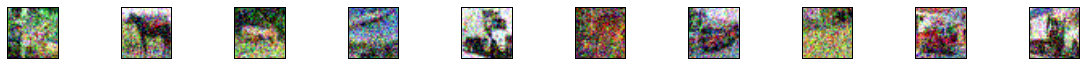

In [38]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    #ax = plt.subplot(1, n, i)
    plt.imshow(s_train_noisy[i].reshape(32, 32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()